<a href="https://colab.research.google.com/github/joonasrooben/OMML_JAB/blob/main/OMML_projet_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#OMML PROJECT

### Imports

In [334]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import math
from scipy.optimize import minimize
import sphinx

### Data analysis

In [335]:
data = pd.read_csv('DATA (1).csv')

In [336]:
data.head(6)

,x1,x2,y
0,1.725110,2.665940,0.101883
1,-1.137973,-1.059821,2.172760
2,1.652338,2.958089,0.118859
3,1.866858,-1.740966,-0.289316
4,-1.760604,1.350072,0.104652
5,1.871249,-0.911920,0.022725


### Split the dataset

We put 0.255 for the test_size instead of 0.25 to be sure to have 186 observations in the training_data

In [337]:
X_train, X_test, y_train, y_test = train_test_split(data[['x1','x2']], data[['y']], test_size=0.255, random_state=1990243)

In [338]:
n = len(X_train)
n

186

### Question 1


#### Question 1.1


**Activation function**

We define the acivation function.

In [339]:

def activationFunction(t, sigma = 1):
  """
  This function is the activation function tanh with two parameters. To optimise our model we have to vary the sigma.
  :param t: input
  :param sigma: the spread σ
  :return:
  """
  return (np.exp(2*sigma*t)-1)/(np.exp(2*sigma*t)+1)

**Weight Initialization for Tanh**

The current standard approach for initialization of the weights of neural network layers and nodes that use the Sigmoid or TanH activation function is called “glorot” or “xavier” initialization

The xavier initialization method is calculated as a random number with a uniform probability distribution (U) between the range -(1/sqrt(n)) and 1/sqrt(n), where n is the number of inputs to the node.

weight = U [-(1/sqrt(n)), 1/sqrt(n)]

Let's define all the hyperparameters here
Let's put 3 neurons in our hidden layer

In [340]:
N = 5
rho = 1
sigma = 1

In [341]:

def createWeightsForOneNeuron(N):
  """
  We want to create a vector of weight using the “xavier” initialization.
  :param N: the number of neurons in the hidden layer
  :return: a array of weights
  """
  initial_weights_one_neuron = []
  for i in range(0,N):
    initial_weights_one_neuron.append(np.random.uniform(low = -(1/math.sqrt(N)), high = 1/math.sqrt(N)))
  return initial_weights_one_neuron

def create_initial_weights(N):
  """
  We want to crate the 2D-matrix of weights "W".
  :param N: the number of neurons in the hidden layer
  :return: a 2D-array of weights
  """
  initial_weights = []
  for i in range(0,2):
    initial_weights.append(createWeightsForOneNeuron(N))
  return initial_weights

In [342]:
def multInputWeights(input, initialWeights):
  """
  We make here the multiplication of the inputs (X) with the weights (W) --> X*W  where X is (n,2) and W is (2,N).
  So we end up with a matrix mult (n,N).
  :param input: inputs
  :param initialWeights: weights of the input
  :return: 2D-array (n,N) dimension
  """
  return np.matmul(input, initialWeights)

Create vector of bias

In [343]:
def createBias(N):
  """
  Creation vector of bias
  :param N: the number of neurons in the hidden layer
  :return: vector of bias
  """
  return np.ones((N,1))

Until now we have the elements to create the equation
$$
 \sum_{i = 1}^{n}{w_{ji}*x_{i} + b_{j}}
$$



In [344]:
def computeLinearResult(mult, bias):
  """
  return the linear regression
  :param mult: multiplication of inputs and weights
  :param bias: vector of bias
  :return: a 2D-array of dimension (n,N)
  """
  return mult + bias.T

We generate weigths for hidden layers


In [345]:
def createWeightsForHiddenLayer(N):
  """
  We want to create a vector of weight using the “xavier” initialization. the vector of weight is V.
  :param N: the number of neurons in the hidden layer
  :return: a array of weights
  """
  weightHiddenLayer = []
  for i in range(0,N):
    weightHiddenLayer.append(np.random.uniform(low = -(1/math.sqrt(N)), high = 1/math.sqrt(N)))
  return weightHiddenLayer

In [346]:

def computeLinearOutput(v, activationOutput):
  return np.matmul(v, activationOutput.T)

Now we have the MLP. We'll computed the regularized training error function E(v,w,b)

In [347]:

def computeEmpiricalRisk(target, output, P):
  """
  Compute empirical risk.

  :param target: this will be the y or f(x1,x2)
  :param output: output of the model
  :param P: number of observations
  :return:
  """
  return (1/(2*P))* sum((output - target)**2)


First create the regularization term



In [348]:
def computeRegularizationTerm(omega, rho = 1):
    """
    Compute the regularization term for the vector ω = (v,w,b).
    :param omega: ω = (v,w,b).
    :return:
    """
    normV = np.linalg.norm(omega[0]**2)
    normW = np.linalg.norm(omega[1]**2)
    normB = np.linalg.norm(omega[2]**2)

    omega_norm = normV + normW + normB

    return (rho/2)*(omega_norm)


To resume a big function we have 

In [349]:
def expectationFunction(omega ,input, target, N, rho, sigma):

  W = omega[:-2*N].reshape((2,N))
  v = omega[-N:]
  bias = omega[-2*N:-N]

  # X*W
  mult = multInputWeights(input, W)

  # sum(X*W) + b
  linearResult = computeLinearResult(mult, bias.T)

  # g(sum(X*W) + b)
  acti = activationFunction(linearResult, sigma)

  # output of the model : sum(v* g(sum(X*W) + b))
  f_x = computeLinearOutput(v, acti)

  # reshape the target
  y = target.to_numpy()
  y = y.reshape((-1))

  # number of observations
  P = len(input)

  expectationRisk = computeEmpiricalRisk(y, f_x, P)

  omega = [v, W, bias]

  regularizationTerm = computeRegularizationTerm(omega, rho)

  return  expectationRisk + regularizationTerm

In [350]:
N = 20
rho = 1e-5
sigma = 1
W = np.array(create_initial_weights(N))
v = np.array(createWeightsForHiddenLayer(N))
bias = createBias(N)
omega = np.append(np.append(W.flatten(), bias), v)

In [381]:
expectationFunction(omega, X_train ,y_train ,N ,rho ,sigma)

1.762605433469565

In [375]:
res = minimize(expectationFunction, omega, args=((X_train ,y_train ,N ,rho ,sigma)), method = 'CG', options={"maxiter":300})

In [383]:
print(res)

[ 2.71440086e-02 -8.64423341e-02 -1.24595695e+00 -7.10427535e-01
 -4.61204382e-01  1.57945517e+00  1.80767974e+00  1.49106657e-01
 -4.07697863e-01  3.81722522e-01  2.14798787e-01  1.02943106e-01
  1.78301220e-01  1.15630329e-01  9.10297051e-02  4.90278927e-01
 -6.97142172e-01 -1.73513928e+00  1.84800485e-01  1.20511169e+00
  1.50969020e+00 -1.22079686e+00  2.47157961e-01 -5.98028921e-01
 -1.95330515e-01  2.92226495e-01 -2.56127482e-01 -1.57205172e-01
 -4.24557606e-01  7.84958833e-04 -4.89422136e-01 -1.60671611e-01
 -4.30597801e-01 -1.57968912e-01 -1.64543737e-01 -1.09904134e+00
 -1.32457375e+00 -2.02478801e-01 -2.91571641e-01 -6.08463651e-01
  1.00076143e+00  2.00500443e+00  9.24714589e-01  1.17162143e+00
  1.50307672e+00  1.06032351e+00  3.39841458e+00  1.02200472e+00
  1.04063709e+00  1.22182192e+00  1.48334670e+00  1.03461984e+00
  1.15329809e+00  9.92737670e-01  1.00448717e+00  8.53366745e-01
  5.22954239e-01  2.75748949e+00  1.05081911e+00  1.82173172e+00
  2.64408730e+00 -1.42343

ValueError: cannot reshape array of size 80 into shape (40,40)

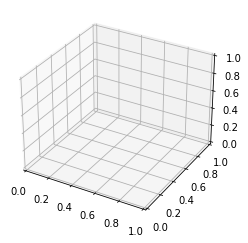

In [380]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plotting(title='Plotting of the function'): #if you do not provide a title, 'Plotting...' will be used
  #create the object
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  n = 100
  #create the grid
  x = np.linspace(-2, 2, n) #create 50 points between [-5,5] evenly spaced
  y = np.linspace(-3, 3, n)
  X, Y = np.meshgrid(x, y) #create the grid for the plot
  #mixed =  np.vstack((X.flatten(),Y.flatten())).T
  #a,b,res = preproc(N,mixed)
  Z = res.jac#evaluate the function (note that X,Y,Z are matrix)
  Z = Z.reshape((n,n))
  print(Z.shape)


  ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='viridis', edgecolor='none')

  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.set_title(title)
  plt.show()

plotting(title = "MLP plot")

*Exercice 2*


In [ ]:
def expectationFunction(omega ,W ,bias ,input, target, N, rho, sigma):

  v = omega[-N:]

  x = input.to_numpy()

  mult = np.matmul(inputs, W)

  linearResult = mult + bias.T

  acti = activationFunction(linearResult, sigma)

  f_x = np.matmul(v,acti.T)

  y = target.to_numpy()
  y = y.reshape((-1)) 

  P = len(input)

  firstTermE = (1/(2*P))* sum((f_x - y)**2)

  omega = [v, W, bias]

  regularizationTerm = (rho/2)*(omega_norm)

  E = firstTermE + regularizationTerm

  return  E

In [ ]:
omega2 = v
W = omega[:-2*N].reshape((2,N))
bias = omega[-2*N:-N]
res = minimize(expectationFunction, omega2, args=((W, bias, X_train ,y_train ,N ,rho ,sigma)), method = 'CG', options={"maxiter":1000})

In [ ]:
print(res)